In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, classification_report, confusion_matrix, roc_curve, auc
from time import time
from wordcloud import WordCloud
import string
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
import nltk
nltk.download('wordnet')
import plotly.express as px
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import html
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import RegexpTokenizer
from nltk import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# set plotting style and figure size for better visualization
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cyberbullying_classification.csv")

Display Basic Information

In [ ]:
print(f"Dataset Shape: {df.shape} \n")
print(f"Target Labels: {df['cyberbullying_type'].unique()}\n")
print(f"Class Distribution:\n{df['cyberbullying_type'].value_counts()}\n")

Dataset Shape: (47692, 2) 

Target Labels: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']

Class Distribution:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64



In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
# Checking for null values
np.sum(df.isnull())

,0
tweet_text,0
cyberbullying_type,0


In [ ]:
# storing the data in lists
tweet, type = list(df['tweet_text']), list(df['cyberbullying_type'])

In [ ]:
df.iloc[0][0]

'In other words #katandandre, your food was crapilicious! #mkr'

In [ ]:
# Encoding the labels
labelencoder = LabelEncoder()

df['cyberbullying_type_encoded'] = labelencoder.fit_transform(df['cyberbullying_type'])

In [ ]:
df[['cyberbullying_type', 'cyberbullying_type_encoded']].value_counts()

,,count
cyberbullying_type,cyberbullying_type_encoded,
religion,5,7998
age,0,7992
gender,2,7973
ethnicity,1,7961
not_cyberbullying,3,7945
other_cyberbullying,4,7823


In [ ]:
# converting tweet text to lowercase
def text_lower(text):
    return text.str.lower()
df.tail()

,tweet_text,cyberbullying_type,cyberbullying_type_encoded
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,1
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,1


Cleaning Dataset

In [ ]:
STOPWORDS = set()  # Initialize as an empty set
try:
    with open("/content/drive/MyDrive/Colab Notebooks/stopwords.txt", "r") as files:
        stopword = files.read()
        stopwordlist = stopword.split()
        STOPWORDS = set(stopwordlist)
except FileNotFoundError:
    print("Error: Stopwords file not found!")

def clean_stopwords(text, stopwords):
    return " ".join([word.lower() for word in str(text).split() if word.lower() not in stopwords])

df['tweet_text'] = df['tweet_text'].apply(lambda text: clean_stopwords(text, stopwords = STOPWORDS))

In [ ]:
# cleaning and removing punctuations
def clean_puctuations(text):
    english_puctuations = string.punctuation
    translator = str.maketrans('', '', english_puctuations)
    return text.translate(translator)

# cleaning and removing repeating characters
def clean_repeating_characters(text):
    return re.sub(r'(.)\1+', r'\1', text)

# cleaning and removing URLs and @ mentions
def clean_URLs(text):
    return re.sub(r"((www\.[^\s]+)|(https?://\S+)|(http?://\S+)|(@\w+))", "", text)

# cleaning and removing numeric data
def clean_numeric(text):
    return re.sub('[0-9]+', '', text)

# Tokenization of tweet text
def tokenize_tweet(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

# stemming
def text_stemming(text):
    st = PorterStemmer()
    return [st.stem(word) for word in text]

# lemmatization
def text_lemmatization(text):
    lm = WordNetLemmatizer()
    return [lm.lemmatize(word) for word in text]

In [ ]:
# Preprocess function (with stopwords argument)
def preprocess(text, stopwords):
    text = text_lower(text)
    text = text.apply(lambda text: clean_stopwords(text, stopwords))
    text = text.apply(clean_puctuations)
    text = text.apply(clean_repeating_characters)
    text = text.apply(clean_URLs)
    text = text.apply(clean_numeric)
    text = text.apply(tokenize_tweet)  # Apply tokenize_tweet directly
    text = text.apply(lambda x: text_stemming(x))
    text = text.apply(lambda x: text_lemmatization(x))
    text = text.apply(lambda x: " ".join(x))
    return text

df['tweet_text'] = preprocess(df['tweet_text'], stopwords=STOPWORDS)
print(df)

                                              tweet_text cyberbullying_type  \
0                      word katandandr fod crapilici mkr  not_cyberbullying   
1      ausietv white mkr theblock imacelebrityau toda...  not_cyberbullying   
2              xochitlsuck clasi whore red velvet cupcak  not_cyberbullying   
3      jasongio meh p thank head up but not concern a...  not_cyberbullying   
4      rudhoenglish isi acount pretend kurdish acount...  not_cyberbullying   
...                                                  ...                ...   
47687  black pl arent expect anyth depend anyth yet f...          ethnicity   
47688  turner not withold disapoint turner cale court...          ethnicity   
47689  swear god dumb niger bitch got bleach hair rea...          ethnicity   
47690  yea fuck therealexel niger fuck unfolow me fuc...          ethnicity   
47691  bro gota chil chilshrami dog fuck kp dumb nige...          ethnicity   

       cyberbullying_type_encoded  
0              

Classification Using Pie Chart

In [ ]:
def performdatadistribution(df):
  sizes = df['cyberbullying_type'].value_counts()
  labeling = df['cyberbullying_type'].unique()
  explode = [0.1, 0, 0, 0, 0, 0]
  plt.pie(sizes, explode = explode, autopct="%1.1f%%", labels = labeling, startangle=180)
  plt.title('Cyber Bullying Type')
  plt.tight_layout()
  plt.show()

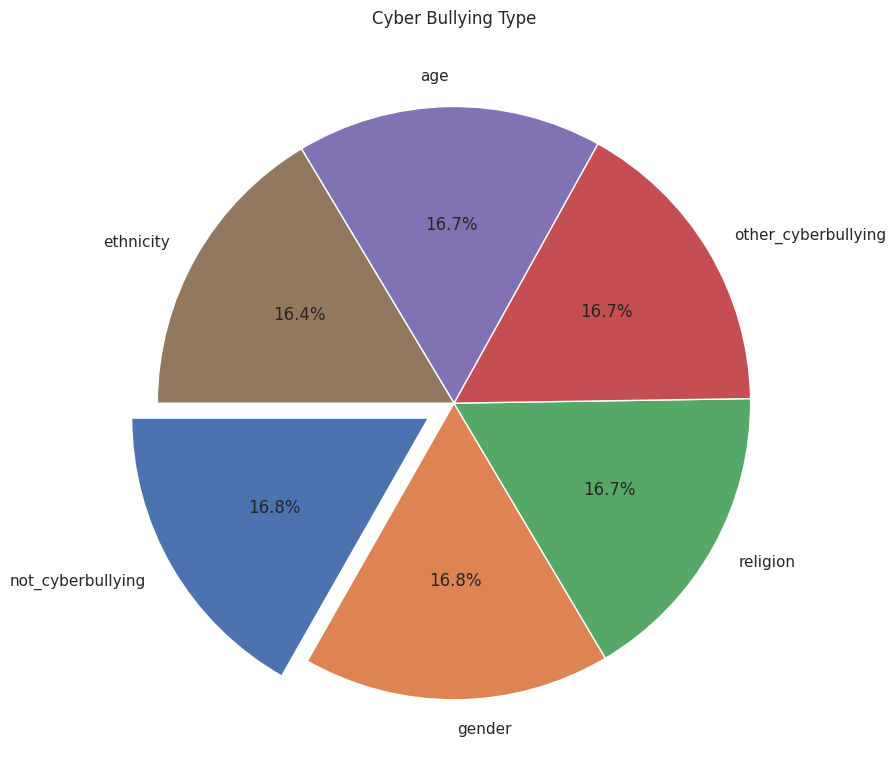

In [ ]:
performdatadistribution(df)

In [49]:
fig = px.bar(
    df.groupby('cyberbullying_type').agg('count').reset_index().rename({'tweet_text':'count'}, axis=1).sort_values('count', ascending=False),
    x='cyberbullying_type',
    y='count',
    color='cyberbullying_type',
    opacity=1,
    color_discrete_sequence=px.colors.diverging.curl,
    template='seaborn',
    title='Label Distribution',
    width=1000,  # Set width (pixels)
    height=600  # Set height (pixels)
)
fig.show()

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cyberbullying_classification.csv")
data = data[data['cyberbullying_type'] != "not_cyberbullying"]
data['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
religion,7998
age,7992
gender,7973
ethnicity,7961
other_cyberbullying,7823


In [ ]:
df.head()

,tweet_text,cyberbullying_type,cyberbullying_type_encoded
0,word katandandr fod crapilici mkr,not_cyberbullying,3
1,ausietv white mkr theblock imacelebrityau toda...,not_cyberbullying,3
2,xochitlsuck clasi whore red velvet cupcak,not_cyberbullying,3
3,jasongio meh p thank head up but not concern a...,not_cyberbullying,3
4,rudhoenglish isi acount pretend kurdish acount...,not_cyberbullying,3


Dataset Splitting

In [ ]:
def performdatasplit(x, y, df):
    # Split the data first
    x_train_text, x_test_text, y_train, y_test = train_test_split(df['tweet_text'], df['cyberbullying_type_encoded'], test_size=x, random_state=y)

    print(f"Number of rows in the total dataset: {df.shape[0]}")
    print(f"Number of rows in the train dataset (text): {x_train_text.shape[0]}")
    print(f"Number of rows in the test dataset (text): {x_test_text.shape[0]}")

    # Initialize and fit the TfidfVectorizer on the training text data
    tfidfvector = TfidfVectorizer(stop_words=list(STOPWORDS), lowercase=True, ngram_range=(1, 2), max_features=30000)
    training_data = tfidfvector.fit_transform(x_train_text.values.astype('U'))

    # Transform the test text data using the fitted vectorizer
    testing_data = tfidfvector.transform(x_test_text.values.astype('U'))

    # Scaling (optional, but if you want to do it, do it after vectorization and splitting)
    scaler = StandardScaler(with_mean=False)
    x_train_scaled = scaler.fit_transform(training_data)
    x_test_scaled = scaler.transform(testing_data)

    filename = 'tfidfvector.pkl'
    pickle.dump(tfidfvector, open(f"/content/drive/MyDrive/Colab Notebooks/{filename}", "wb"))

    return x_train_scaled, x_test_scaled, y_train, y_test, testing_data, filename, training_data, STOPWORDS, x_train_text, x_test_text # Return the original text splits

In [ ]:
x_train, x_test, y_train, y_test, testing_data, filename, training_data, STOPWORDS, x_train_text, x_test_text = performdatasplit(0.2, 42, df)

Number of rows in the total dataset: 47692
Number of rows in the train dataset (text): 38153
Number of rows in the test dataset (text): 9539


Apply Machine Learning Algorithm

In [ ]:
def pipeline(x_train, y_train, x_test, y_test):
  MODELS = [LinearSVC(), LogisticRegression(max_iter=500), MultinomialNB(), DecisionTreeClassifier(),
            AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
  size = len(y_train)
  results = {}
  final_results = []
  for model in MODELS:
    results['Algorithm'] = model.__class__.__name__

    start = time()
    print(f"Training Time: {model.__class__.__name__}")
    model.fit(x_train, y_train)
    end= time()

    filename = model.__class__.__name__+".pkl"
    pickle.dump(model, open(f"/content/drive/MyDrive/Colab Notebooks/{filename}", "wb"))

    results['Training Time'] = end - start

    start = time()
    print(f"Prediction Time: {model.__class__.__name__}")
    prediction_test = model.predict(x_test)
    prediction_train = model.predict(x_train)
    end = time()

    results['Prediction Time'] = end - start

    results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
    results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)

    results['F1 Score : Test'] = f1_score(y_test, prediction_test, average='weighted')
    results['F1 Score : Train'] = f1_score(y_train, prediction_train, average='weighted')

    results['Precision : Test'] = precision_score(y_test, prediction_test, average='weighted')
    results['Precision : Train'] = precision_score(y_train, prediction_train, average='weighted')

    results['Recall : Test'] = recall_score(y_test, prediction_test, average='weighted')
    results['Recall : Train'] = recall_score(y_train, prediction_train, average='weighted')
    print(f"Training {model.__class__.__name__} finished in {results['Training Time']:.2f} sec\n")

    final_results.append(results.copy())
  return final_results

In [ ]:
final_results = pipeline(training_data, y_train, testing_data, y_test)

Training Time: LinearSVC
Prediction Time: LinearSVC
Training LinearSVC finished in 2.05 sec

Training Time: LogisticRegression
Prediction Time: LogisticRegression
Training LogisticRegression finished in 21.40 sec

Training Time: MultinomialNB
Prediction Time: MultinomialNB
Training MultinomialNB finished in 0.02 sec

Training Time: DecisionTreeClassifier
Prediction Time: DecisionTreeClassifier
Training DecisionTreeClassifier finished in 25.15 sec

Training Time: AdaBoostClassifier
Prediction Time: AdaBoostClassifier
Training AdaBoostClassifier finished in 8.07 sec

Training Time: BaggingClassifier
Prediction Time: BaggingClassifier
Training BaggingClassifier finished in 133.71 sec

Training Time: SGDClassifier
Prediction Time: SGDClassifier
Training SGDClassifier finished in 0.57 sec



In [ ]:
def performfinalresult(final_results):
  results = pd.DataFrame(final_results)
  results.reindex(columns=['Algorithm', 'Training Time', 'Prediction Time', 'Accuracy : Test', 'Accuracy : Train', 'F1 Score : Test', 'F1 Score : Train', 'Precision : Test', 'Precision : Train', 'Recall : Test', 'Recall : Train'])
  results.sort_values(by= 'F1 Score : Test', inplace=True, ascending=False)
  return results

In [ ]:
results = performfinalresult(final_results)
results.reset_index(drop=True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,SGDClassifier,0.565433,0.024595,0.831010,0.893639,0.825163,0.890531,0.825313,0.893188,0.831010,0.893639
1,LogisticRegression,21.403256,0.021750,0.822833,0.909208,0.824183,0.909442,0.826260,0.911005,0.822833,0.909208
2,LinearSVC,2.049511,0.022228,0.811615,0.951459,0.811483,0.951373,0.811456,0.951675,0.811615,0.951459
3,BaggingClassifier,133.705358,0.649569,0.795052,0.958299,0.797011,0.958259,0.799558,0.958300,0.795052,0.958299
4,DecisionTreeClassifier,25.145113,0.061072,0.781109,0.967421,0.784008,0.967132,0.787190,0.969307,0.781109,0.967421
5,MultinomialNB,0.016397,0.013761,0.775867,0.853092,0.758446,0.844718,0.763167,0.851233,0.775867,0.853092
6,AdaBoostClassifier,8.067559,1.672145,0.687179,0.690640,0.674163,0.681378,0.738707,0.748605,0.687179,0.690640


In [ ]:
results.describe().loc[['min','max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.016397,0.013761,0.687179,0.690640,0.674163,0.681378,0.738707,0.748605,0.687179,0.690640
max,133.705358,1.672145,0.831010,0.967421,0.825163,0.967132,0.826260,0.969307,0.831010,0.967421


Summary In Graph

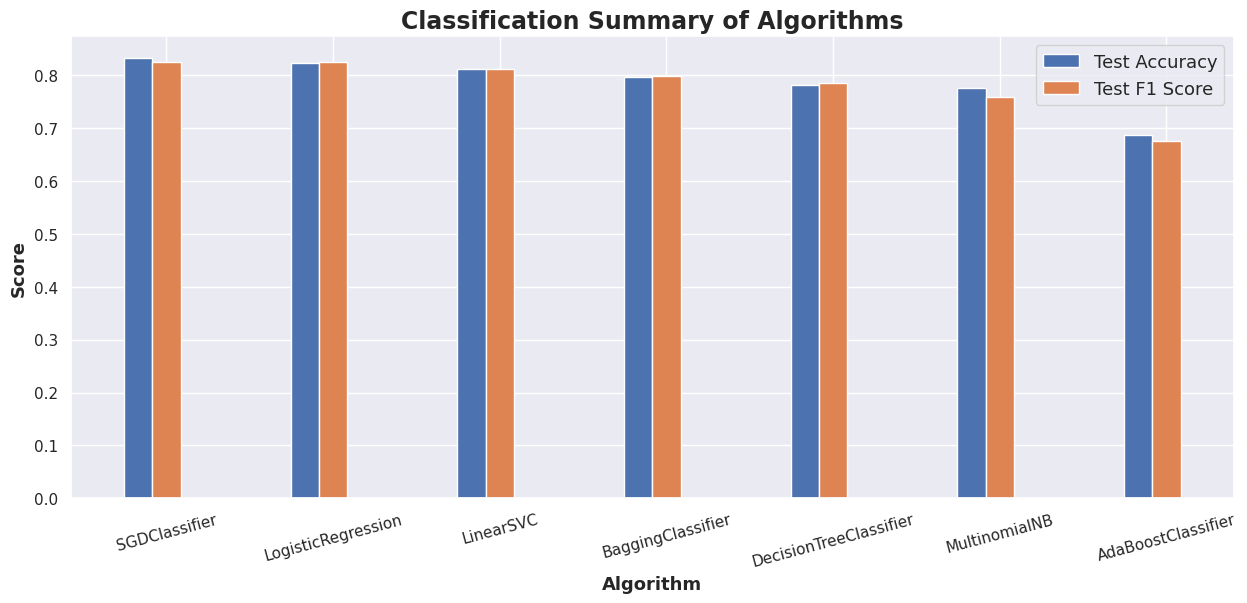

In [ ]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17

# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]),
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Training and Prediction time of Algorithm

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

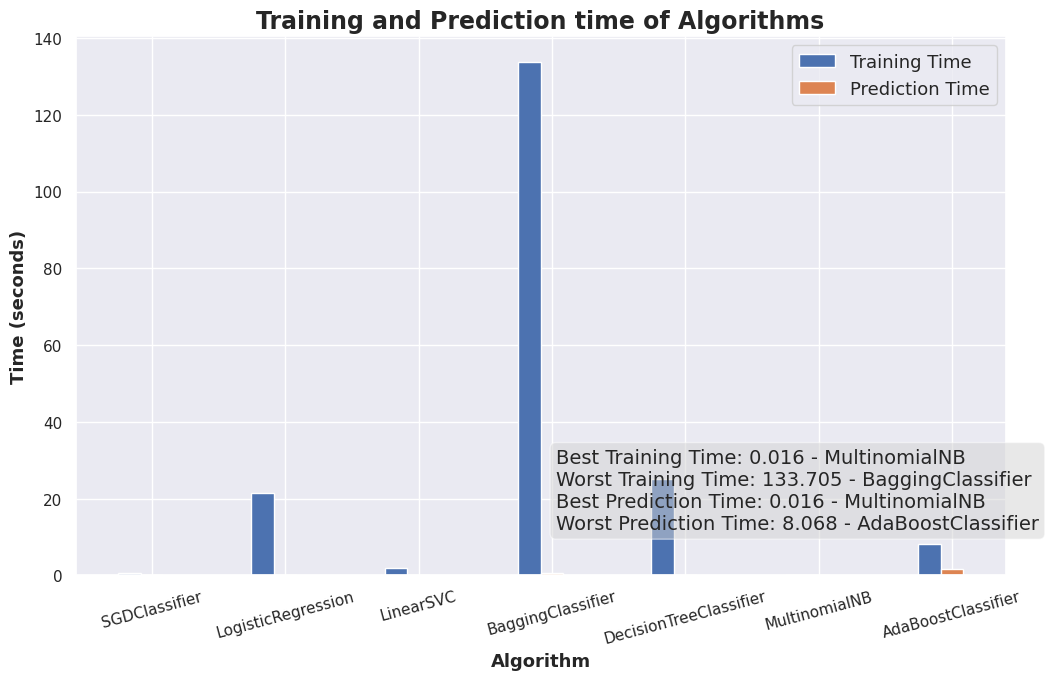

In [ ]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17

# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]),
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]),
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props)

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

Testing Model

In [ ]:
import html
data = [html.unescape("@dgettings tweetsave breaks dev policy iirc. >.>")]

with open("/content/drive/MyDrive/Colab Notebooks/tfidfvector.pkl", "rb") as file:
    loaded_tfidf = pickle.load(file)

vocabulary = loaded_tfidf.vocabulary_

tfidf_vector = TfidfVectorizer(stop_words=list(STOPWORDS), lowercase=True, vocabulary=vocabulary)
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LinearSVC.pkl", "rb"))
predictions = trained_model.predict(preprocessed_data)

interpretations = {
    0: "Age",
    1: "Ethnicity",
    2: "Gender",
    3: "Not Cyberbullying",
    4: "Other Cyberbullying",
    5: "Religion"
}

# Access the prediction value from the array
prediction_value = predictions[0]

for i in interpretations.keys():
    if i == prediction_value:
        print(interpretations[i])

Other Cyberbullying


Fine Tuning Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder

def tuning(clf, param_dict, x_train, y_train, x_test, y_test):
    scorer = make_scorer(f1_score, average='weighted')

    # grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=StratifiedKFold(n_splits=5)) -- This is alot slower
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=3,  n_jobs=-1)
    grid_fit = grid_obj.fit(x_train, y_train)
    best_clf = grid_fit.best_estimator_
    best_prediction = best_clf.predict(x_test)

    # Print results
    print(clf.__class__.__name__)
    print(f"Best Parameters: {grid_fit.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, best_prediction)}")
    print(f"F1 Score: {f1_score(y_test, best_prediction, average='weighted')}")
    print(f"Precision: {precision_score(y_test, best_prediction, average='weighted')}")
    print(f"Recall: {recall_score(y_test, best_prediction, average='weighted')}")

In [ ]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()
clf_model = clf_model.fit(training_data, y_train)

tuning(clf_model, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC
Best Parameters: {'C': 0.25}
Accuracy: 0.8243002411154209
F1 Score: 0.8235300237537141
Precision: 0.8234693123549263
Recall: 0.8243002411154209


In [ ]:
pickle.dump(clf_model, open(f"/content/drive/MyDrive/Colab Notebooks/LinearSVCTuned.pkl", "wb"))

In [ ]:
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve - {model_name}", fontsize=14)
    plt.xlabel("Training examples", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# this function trains a model, evaluates it with cv, and returns performance metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Trains a model, evaluates it, and returns performance metrics.  Includes
    ROC AUC for binary and multi-class cases (using OneVsRestClassifier).
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time for {model_name}: {training_time:.2f} seconds")

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if len(np.unique(y_test)) == 2:  # Binary classification
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
    else:  # Multi-class classification
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_test, y_pred)

    start_time_cv = time.time()
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_time = time.time() - start_time_cv
    print(f"Cross-validation time: {cv_time:.2f} seconds")
    print(f"Cross-Validation Accuracy (3-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    roc_auc = None
    fpr = None
    tpr = None
    plot_roc = True  # Flag to control ROC curve plotting

    plt.figure(figsize=(15, 5))  # Create the figure *before* the checks

    # Confusion Matrix (always plotted)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # ROC Curve (conditional plotting)
    plt.subplot(1, 2, 2)  # Put the subplot here, even if we don't plot in it

    if hasattr(model, "predict_proba") or isinstance(model, OneVsRestClassifier):
        try:
            y_bin = label_binarize(y_test, classes=np.unique(y_test))
            n_classes = y_bin.shape[1]

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)
            else:  # For OneVsRestClassifier with LinearSVC (uses decision_function)
                y_prob = model.decision_function(X_test)

            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Check if any AUC is valid before plotting
            if any(0.0 <= val <= 1.0 for val in roc_auc.values()):
                plt.plot([0, 1], [0, 1], 'k--', lw=2)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'Multi-class ROC Curve - {model_name}', fontsize=14)
                for i in range(n_classes):
                    plt.plot(fpr[i], tpr[i], lw=2,
                             label=f'ROC curve of class {np.unique(y_test)[i]} (area = {roc_auc[i]:.2f})')
                plt.legend(loc="lower right")
            else:
                print("Warning: ROC AUC values are invalid. Not plotting ROC curve.")
                plot_roc = False  # Set the flag to prevent plotting
                roc_auc = None
                fpr = None
                tpr = None

        except Exception as e:
            print(f"Warning: Could not compute multi-class ROC AUC: {e}")
            plot_roc = False  # Set the flag
            roc_auc = None
            fpr = None
            tpr = None

    elif hasattr(model, "decision_function") and len(np.unique(y_test)) == 2:  # Binary
        try:
            y_score = model.decision_function(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            if 0.0 <= roc_auc <= 1.0:
                plt.plot([0, 1], [0, 1], 'k--', lw=2)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - {model_name}', fontsize=14)
                plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.legend(loc="lower right")
            else:
                print("Warning: ROC AUC value is invalid. Not plotting ROC curve.")
                plot_roc = False
                roc_auc = None
                fpr = None
                tpr = None
        except Exception as e:
            print(f"Warning: Could not compute ROC AUC (decision_function issue): {e}")
            plot_roc = False
            roc_auc = None
            fpr = None
            tpr = None
    else:
        print("Warning: Could not compute ROC AUC. Model might not support required functions.")
        plot_roc = False
        roc_auc = None
        fpr = None
        tpr = None

    if plot_roc:
        plt.tight_layout()
        plt.show()  # Only show if the flag is still True

    plot_learning_curve(model, x_train, y_train, model_name)

    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'cv_scores': cv_scores,
        'report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
    }

Training time for Linear SVC (OvR): 2.44 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1603
           1       0.97      0.97      0.97      1603
           2       0.88      0.85      0.86      1531
           3       0.55      0.54      0.55      1624
           4       0.59      0.60      0.59      1612
           5       0.94      0.95      0.95      1566

    accuracy                           0.81      9539
   macro avg       0.81      0.81      0.81      9539
weighted avg       0.81      0.81      0.81      9539

Cross-validation time: 4.02 seconds
Cross-Validation Accuracy (3-fold): 0.8195 (+/- 0.0037)


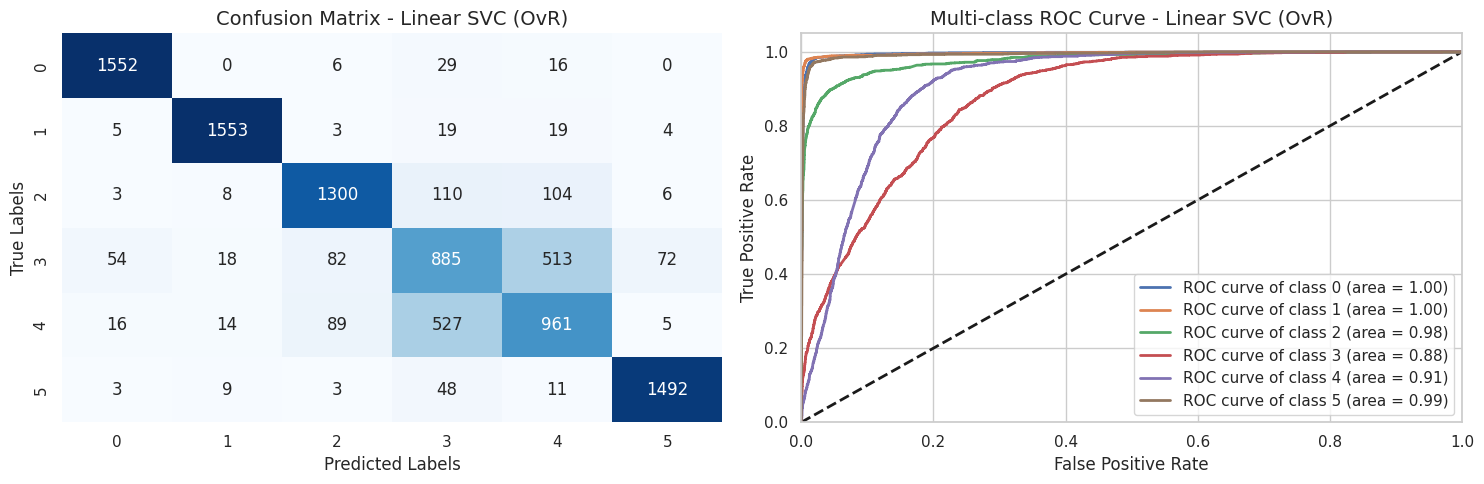

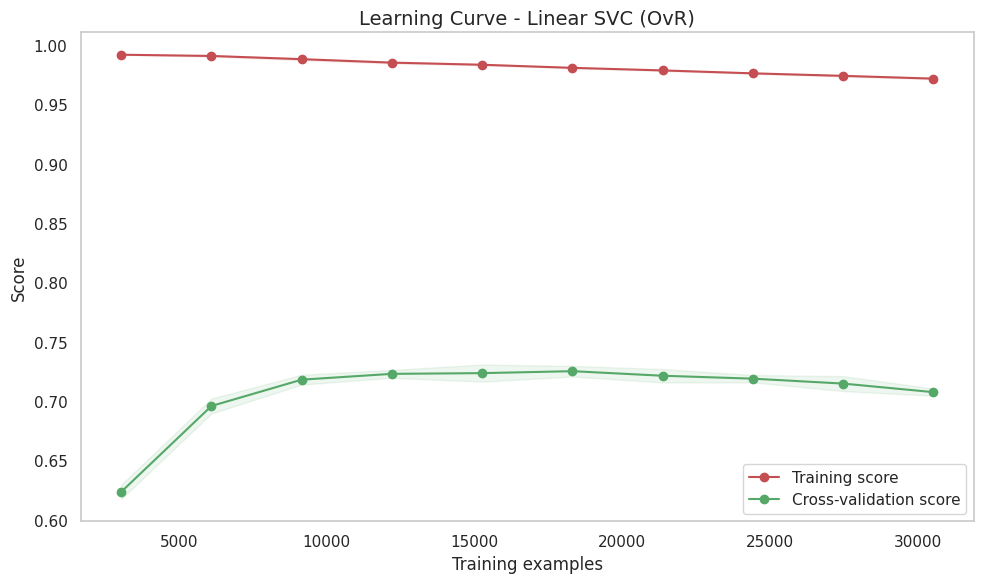

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Check the number of unique classes in y_train (or y_test)
num_classes = len(np.unique(y_train))

if num_classes > 2:
    lsvc = OneVsRestClassifier(LinearSVC(random_state=42))
    lsvc_results = evaluate_model(lsvc, training_data, testing_data, y_train, y_test, "Linear SVC (OvR)")
elif num_classes == 2:
    lsvc = LinearSVC(random_state=42)
    lsvc_results = evaluate_model(lsvc, training_data, testing_data, y_train, y_test, "Linear SVC")
else:
    print("Warning: Only one class found in the target variable. ROC AUC cannot be computed.")
    lsvc = LinearSVC(random_state=42)
    lsvc_results = evaluate_model(lsvc, training_data, testing_data, y_train, y_test, "Linear SVC")

Training time for Random Forest: 114.43 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1603
           1       0.98      0.98      0.98      1603
           2       0.89      0.84      0.86      1531
           3       0.56      0.52      0.54      1624
           4       0.56      0.62      0.59      1612
           5       0.96      0.95      0.95      1566

    accuracy                           0.81      9539
   macro avg       0.82      0.81      0.82      9539
weighted avg       0.82      0.81      0.81      9539

Cross-validation time: 191.89 seconds
Cross-Validation Accuracy (3-fold): 0.8170 (+/- 0.0070)


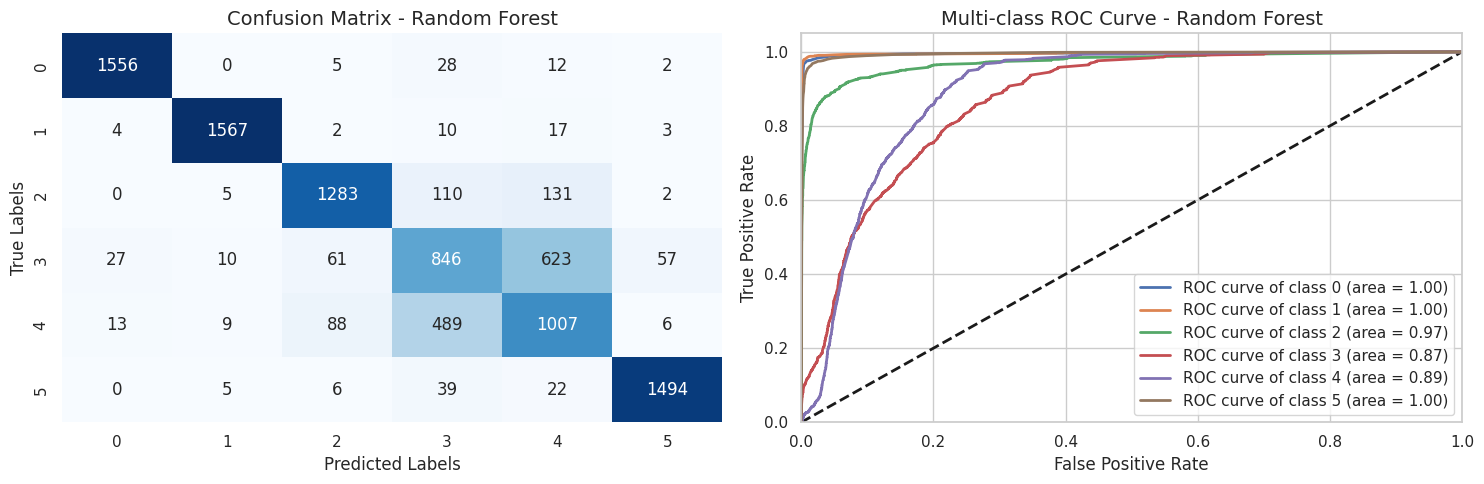

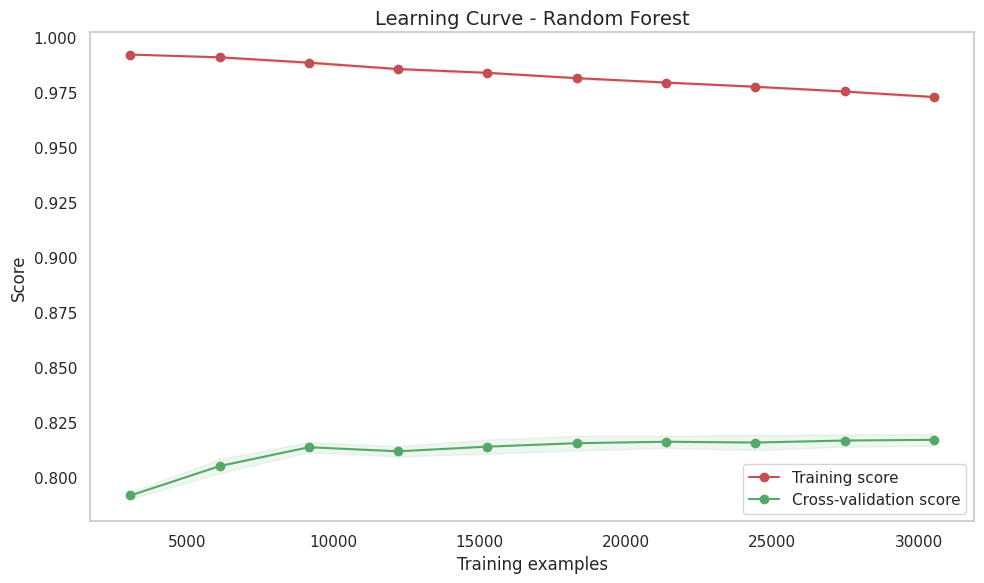

In [ ]:
# using RFC (Random Forest Classification) with already defined cross validation function
rf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
rf_results = evaluate_model(rf, x_train, x_test, y_train, y_test, "Random Forest")

Training time for Logistic Regression: 48.69 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1603
           1       0.93      0.90      0.92      1603
           2       0.79      0.77      0.78      1531
           3       0.43      0.46      0.45      1624
           4       0.47      0.48      0.48      1612
           5       0.90      0.87      0.89      1566

    accuracy                           0.73      9539
   macro avg       0.74      0.73      0.73      9539
weighted avg       0.73      0.73      0.73      9539

Cross-validation time: 54.52 seconds
Cross-Validation Accuracy (3-fold): 0.7468 (+/- 0.0040)


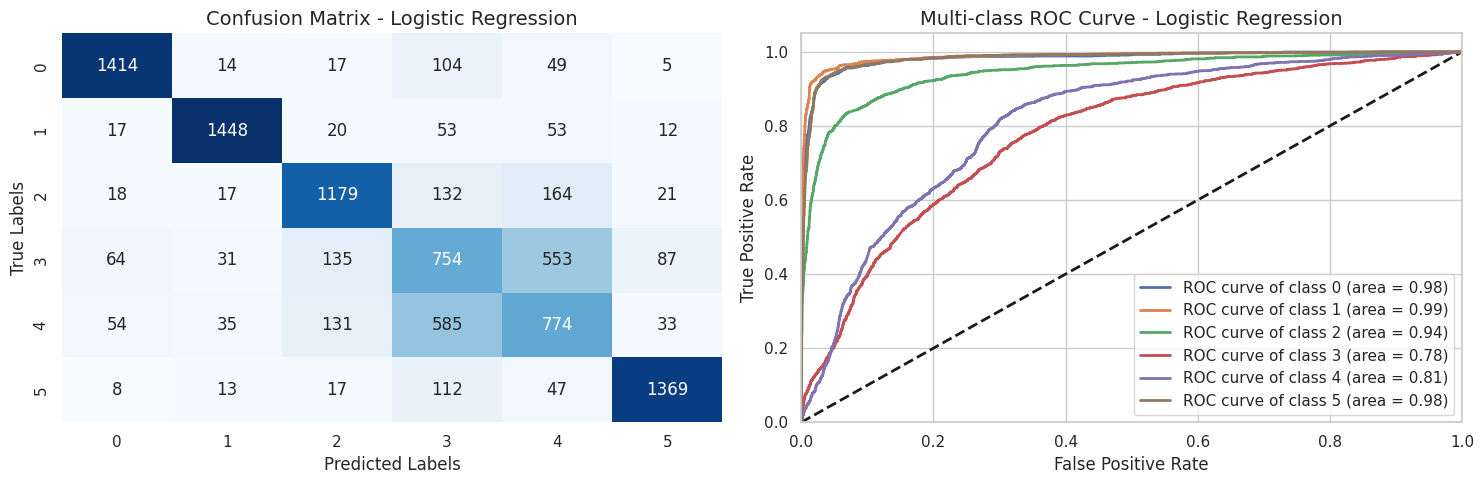

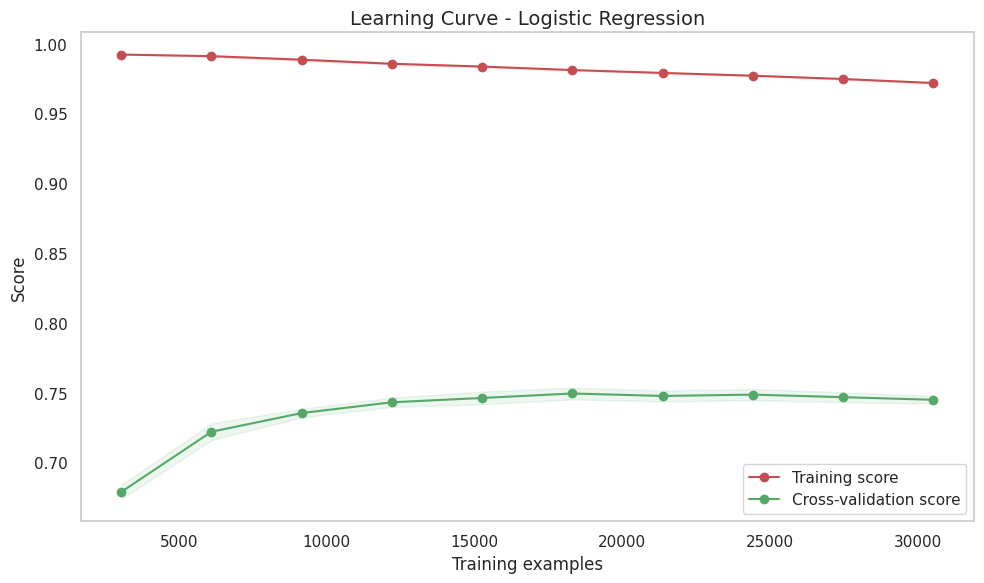

In [ ]:
log_reg = LogisticRegression(random_state=42, solver='liblinear')
log_reg_results = evaluate_model(log_reg, x_train, x_test, y_train, y_test, "Logistic Regression")

Model Comparison:
                 Model  Test Accuracy  CV Mean Accuracy    CV Std   ROC AUC
0           Linear SVC       0.693050          0.711399  0.008791  0.894026
1        Random Forest       0.812769          0.816974  0.003509  0.953898
2  Logistic Regression       0.727330          0.746783  0.002006  0.914336


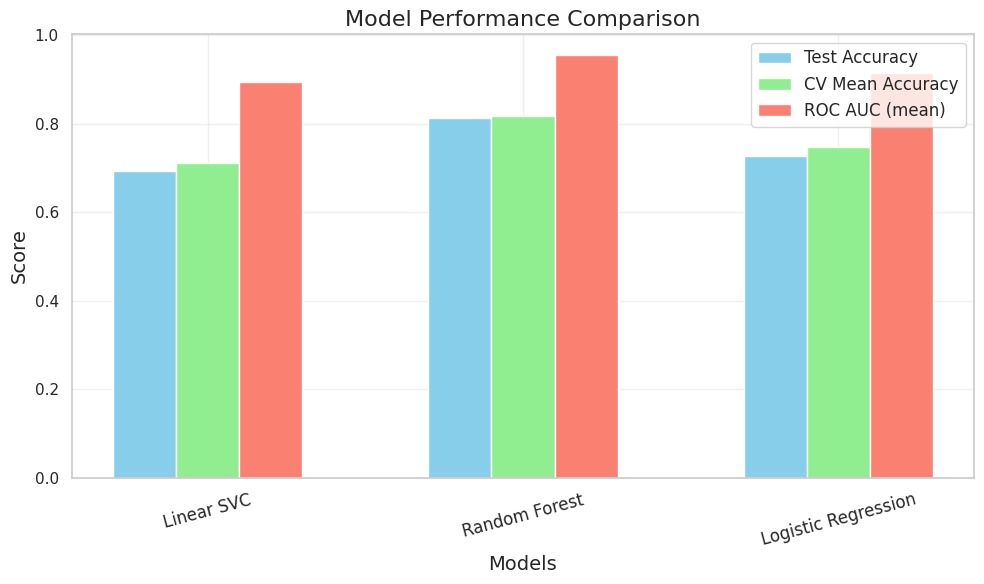

In [ ]:
# comparing model performances
# models = ['Linear SVC', 'Random Forest', 'SVM', 'Logistic Regression']
# accuracies = [lsvc_results['accuracy'], rf_results['accuracy'], svm_results['accuracy'], lr_results['accuracy']]
# cv_means = [lsvc_results['cv_scores'].mean(), rf_results['cv_scores'].mean(), svm_results['cv_scores'].mean(), lr_results['cv_scores'].mean()]
# cv_stds = [lsvc_results['cv_scores'].std(), rf_results['cv_scores'].std(), svm_results['cv_scores'].std(), lr_results['cv_scores'].std()]
# roc_aucs = [lsvc_results['roc_auc'], rf_results['roc_auc'], svm_results['roc_auc'], lr_results['roc_auc']]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use the results from the model evaluations
models = ['Linear SVC', 'Random Forest', 'Logistic Regression']
accuracies = [lsvc_results['accuracy'], rf_results['accuracy'], log_reg_results['accuracy']]
cv_means = [lsvc_results['cv_scores'].mean(), rf_results['cv_scores'].mean(), log_reg_results['cv_scores'].mean()]
cv_stds = [lsvc_results['cv_scores'].std(), rf_results['cv_scores'].std(), log_reg_results['cv_scores'].std()]

# Handle the case where roc_auc might be None or a dictionary
roc_aucs = []
for result in [lsvc_results, rf_results, log_reg_results]:
    if result['roc_auc'] is None:
        roc_aucs.append(0.5)  # Default value if ROC AUC is not available
    elif isinstance(result['roc_auc'], dict):
        # Take the mean of all class AUCs if it's a dictionary
        roc_aucs.append(np.mean(list(result['roc_auc'].values())))
    else:
        roc_aucs.append(result['roc_auc'])

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Test Accuracy': accuracies,
    'CV Mean Accuracy': cv_means,
    'CV Std': cv_stds,
    'ROC AUC': roc_aucs  # Use the list we constructed
})

print("Model Comparison:")
print(comparison_df)

# Visualize model comparison
plt.figure(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(models))

plt.bar(index, accuracies, bar_width, label='Test Accuracy', color='skyblue')
plt.bar(index + bar_width, cv_means, bar_width, label='CV Mean Accuracy', color='lightgreen')
plt.bar(index + 2 * bar_width, roc_aucs, bar_width, label='ROC AUC (mean)', color='salmon')

plt.xlabel('Models', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)
plt.xticks(index + bar_width, models, rotation=15, ha='center', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
LinearSVC Best Parameters: {'estimator__C': 0.1, 'estimator__loss': 'squared_hinge', 'estimator__tol': 0.001}
LinearSVC Best Cross-Validation Score: 0.7061306333777035
Training time for Tuned Linear SVC: 24.06 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      1603
           1       0.92      0.86      0.89      1603
           2       0.76      0.74      0.75      1531
           3       0.40      0.46      0.42      1624
           4       0.42      0.48      0.45      1612
           5       0.89      0.79      0.84      1566

    accuracy                           0.69      9539
   macro avg       0.72      0.69      0.70      9539
weighted avg       0.71      0.69      0.70      9539

Cross-validation time: 45.95 seconds
Cross-Validation Accuracy (3-fold): 0.7059 (+/- 0.0069)


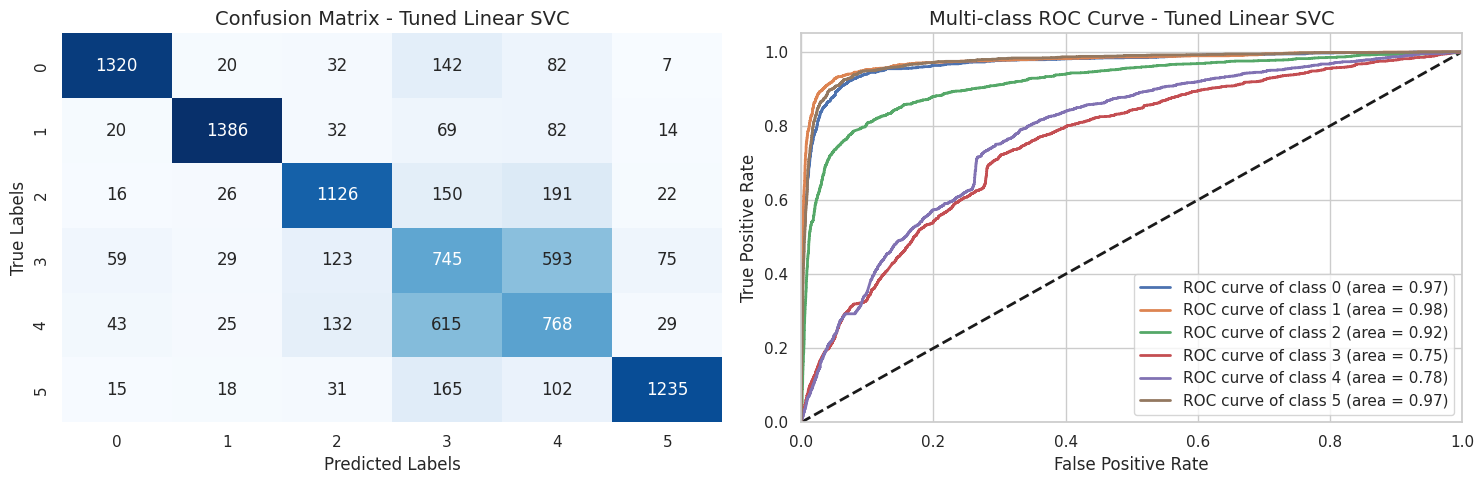

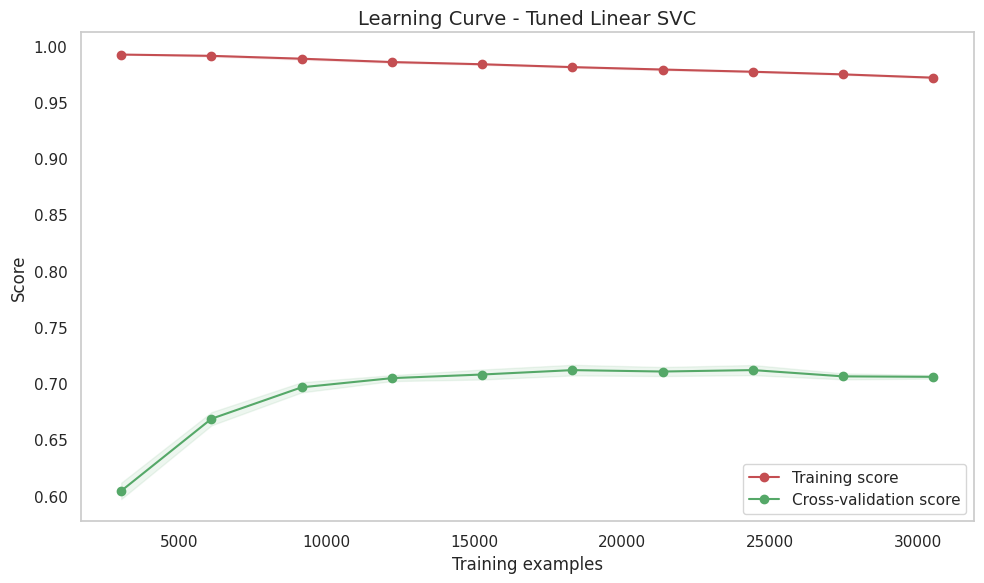

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

# 1. Optimized LinearSVC Hyperparameter Tuning
lsvc_param_grid = {
    'estimator__C': [0.1, 1],  # Further reduced range based on typical optimal values
    'estimator__loss': ['squared_hinge'],  # More stable than hinge
    'estimator__tol': [1e-3]  # Slightly looser tolerance for faster convergence
}

num_classes = len(np.unique(y_train))
if num_classes > 2:
    base_svc = LinearSVC(
        random_state=42,
        dual=False,
        max_iter=2000,  # Increased from default but not excessive
        class_weight='balanced'  # Handle class imbalance
    )
    lsvc = OneVsRestClassifier(base_svc, n_jobs=-1)  # Parallelize multiclass
else:
    lsvc = LinearSVC(
        random_state=42,
        dual=False,
        max_iter=2000,
        class_weight='balanced'
    )

# Reduced folds for large dataset
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lsvc_grid = GridSearchCV(
    lsvc,
    param_grid=lsvc_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  # Add progress monitoring
)

lsvc_grid.fit(x_train, y_train)

print("LinearSVC Best Parameters:", lsvc_grid.best_params_)
print("LinearSVC Best Cross-Validation Score:", lsvc_grid.best_score_)

best_lsvc = lsvc_grid.best_estimator_
lsvc_tuned_results = evaluate_model(best_lsvc, x_train, x_test, y_train, y_test, "Tuned Linear SVC")

Random Forest Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best Cross-Validation Score: 0.7785231997579027
Training time for Tuned Random Forest: 4.35 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      1603
           1       0.97      0.92      0.94      1603
           2       0.94      0.73      0.82      1531
           3       0.47      0.71      0.57      1624
           4       0.58      0.39      0.46      1612
           5       0.91      0.95      0.93      1566

    accuracy                           0.78      9539
   macro avg       0.80      0.78      0.78      9539
weighted avg       0.80      0.78      0.78      9539

Cross-validation time: 24.67 seconds
Cross-Validation Accuracy (3-fold): 0.7827 (+/- 0.0026)


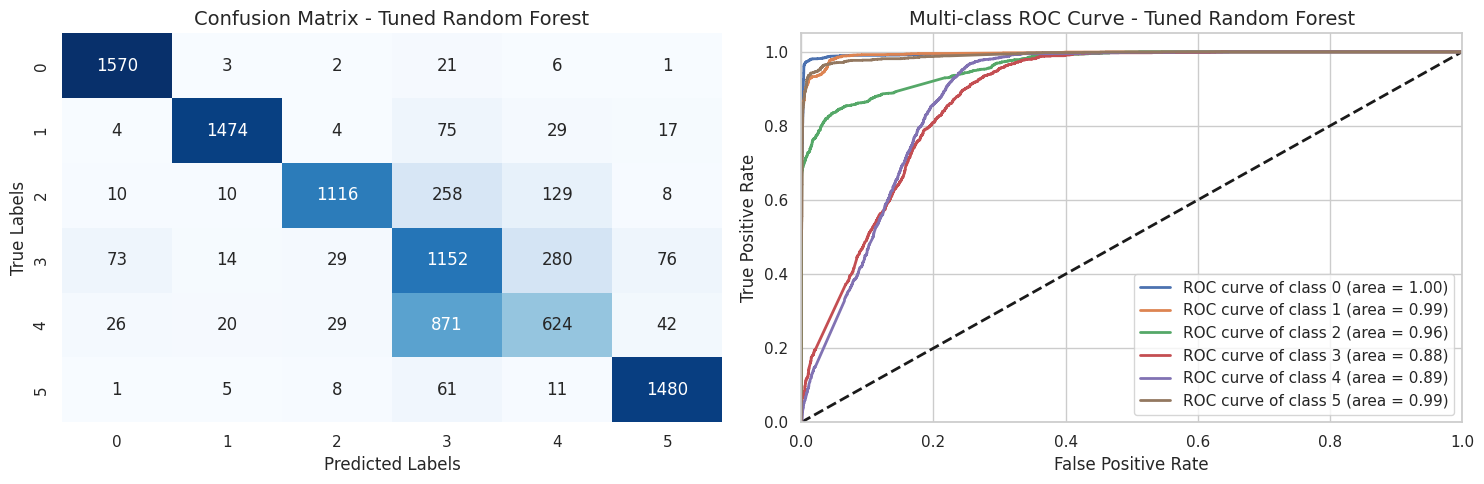

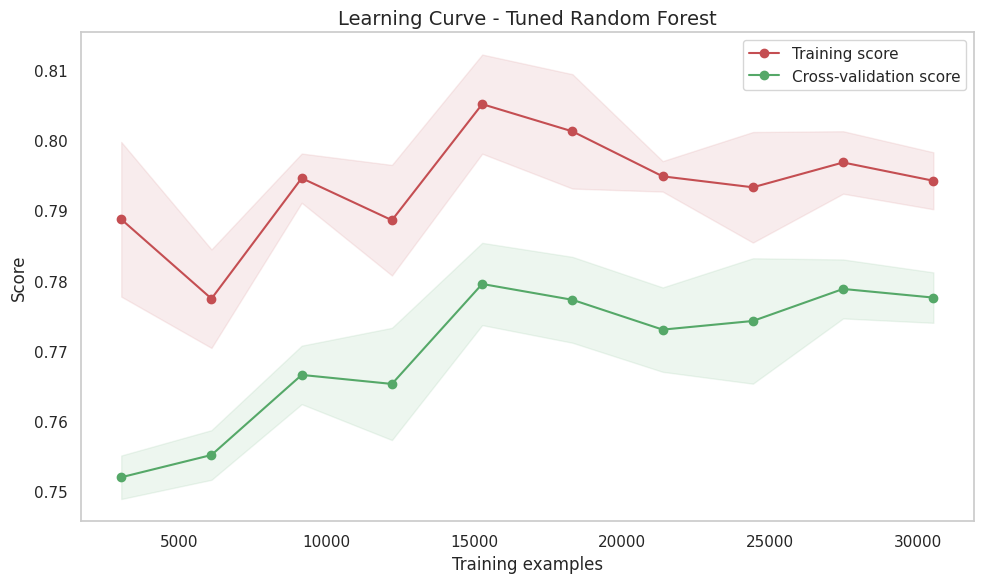

In [ ]:
# 1. Random Forest Hyperparameter Tuning (Optimized)
rf_param_grid = {
    'n_estimators': [100, 200],  # Keep reasonable range
    'max_depth': [10, 20],       # Changed from None to avoid overfitting
    'min_samples_split': [2, 5],  # Reduced upper range
    'min_samples_leaf': [1, 2]    # Reduced upper range
}

# Use StratifiedKFold for better performance on classification tasks
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores for parallel processing
)

rf_grid.fit(x_train, y_train)

print("Random Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Best Cross-Validation Score:", rf_grid.best_score_)

# Use best model for final evaluation
best_rf = rf_grid.best_estimator_
rf_tuned_results = evaluate_model(best_rf, x_train, x_test, y_train, y_test, "Tuned Random Forest")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=  39.8s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=  38.8s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=  37.6s
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time=  37.2s
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time=  37.5s
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time=  38.5s
[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=  37.2s
[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=  37.1s
[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=  38.3s
Logistic Regression Best Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Best Score: 0.7560
Training time for Tuned Logistic Regression: 56.99 seconds
Classific

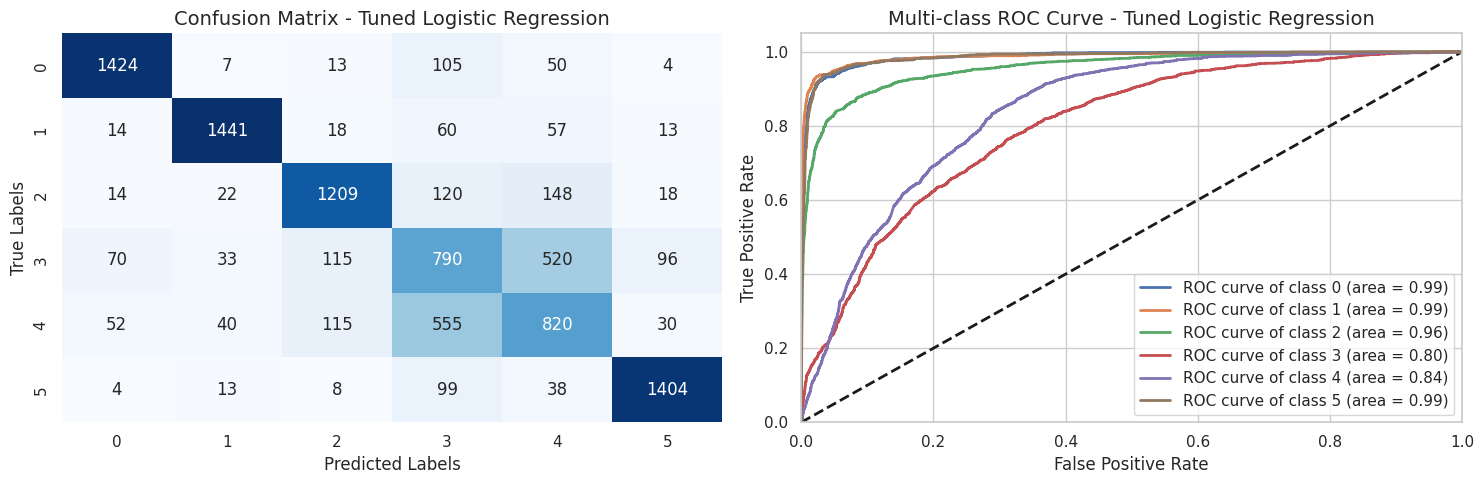

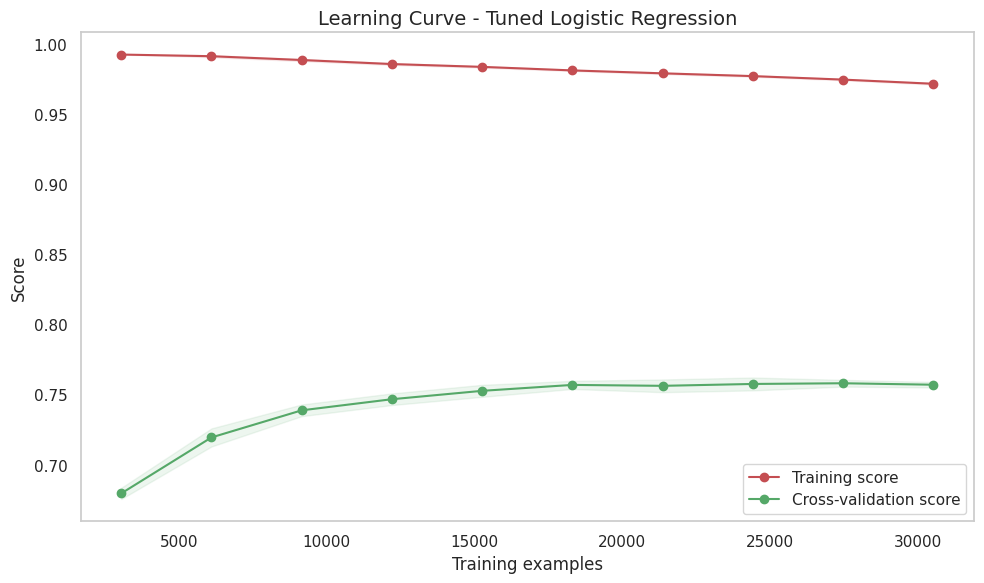

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import numpy as np

# 3. Optimized Logistic Regression Tuning
lr_param_grid = {
    'C': [0.1, 1, 10],  # Adjusted range based on common optimal values
    'penalty': ['l2'],   # Start with just L2 for stability
    'solver': ['saga'],  # Best for large datasets
    'class_weight': [None]  # Removed balanced to reduce complexity
}

# More efficient CV strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Simplified model configuration
base_lr = LogisticRegression(
    random_state=42,
    max_iter=1000,          # Increased iterations for convergence
    tol=1e-4,              # Balanced tolerance
    solver='saga',
    n_jobs=-1,             # Parallel processing
    warm_start=False,      # Disabled for more reliable results
    multi_class='auto'     # Let sklearn determine automatically
)

lr_grid = GridSearchCV(
    estimator=base_lr,
    param_grid=lr_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=1,              # Reduced to avoid memory issues
    verbose=2,             # More detailed progress
    error_score='raise'    # Get immediate feedback on failures
)

try:
    lr_grid.fit(x_train, y_train)

    print("Logistic Regression Best Parameters:", lr_grid.best_params_)
    print("Logistic Regression Best Score: {:.4f}".format(lr_grid.best_score_))

    best_lr = lr_grid.best_estimator_
    lr_tuned_results = evaluate_model(best_lr, x_train, x_test, y_train, y_test, "Tuned Logistic Regression")

except Exception as e:
    print(f"Optimization failed: {str(e)}")
    print("Trying fallback configuration...")

    # Fallback simple model
    simple_lr = LogisticRegression(
        C=1,
        penalty='l2',
        solver='saga',
        max_iter=1000,
        random_state=42
    )
    simple_lr.fit(x_train, y_train)
    lr_tuned_results = evaluate_model(simple_lr, x_train, x_test, y_train, y_test, "Fallback Logistic Regression")

Tuned Model Comparison:
                       Model  Test Accuracy  CV Mean Accuracy    CV Std  \
0            Tuned LinearSVC       0.689800          0.705947  0.003443   
1        Tuned Random Forest       0.777440          0.782665  0.001290   
2  Tuned Logistic Regression       0.743055          0.757660  0.001229   

    ROC AUC  
0  0.894925  
1  0.952735  
2  0.926052  


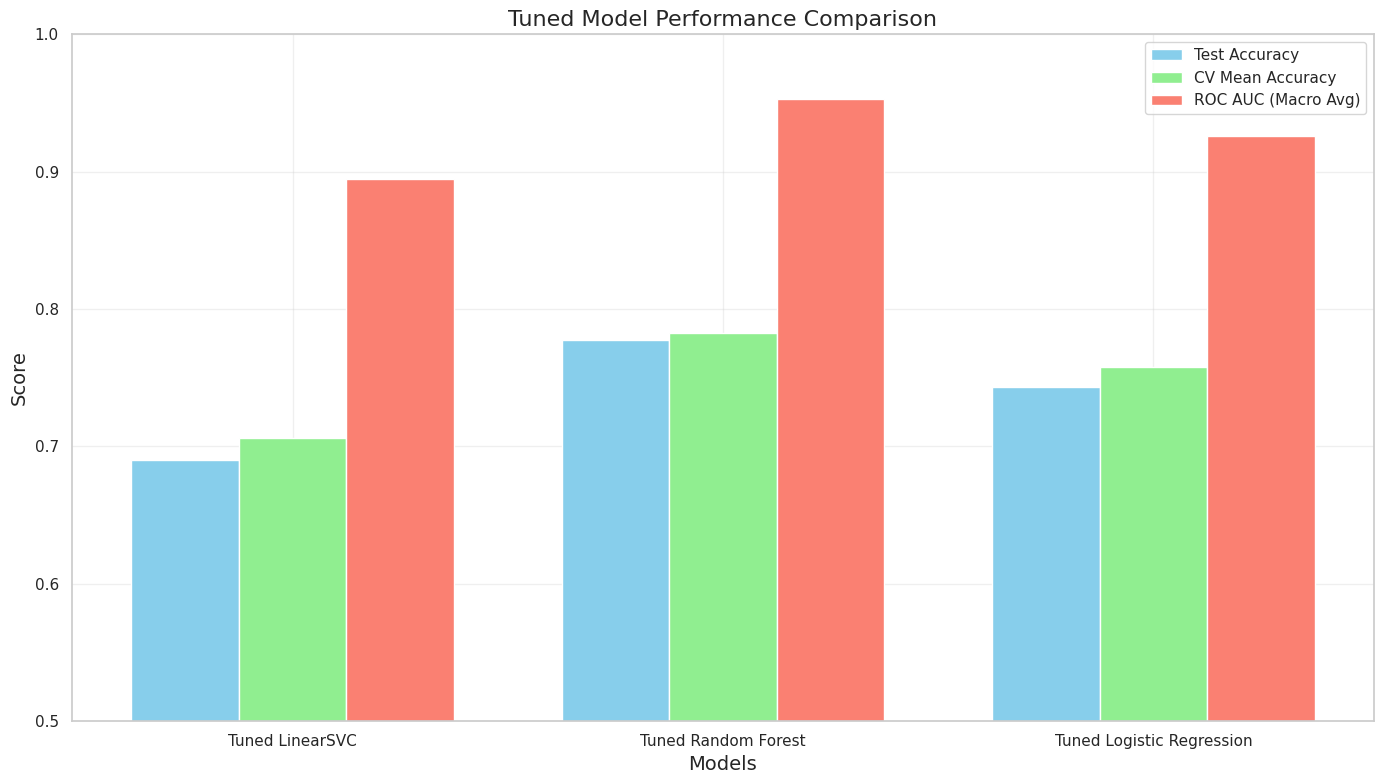

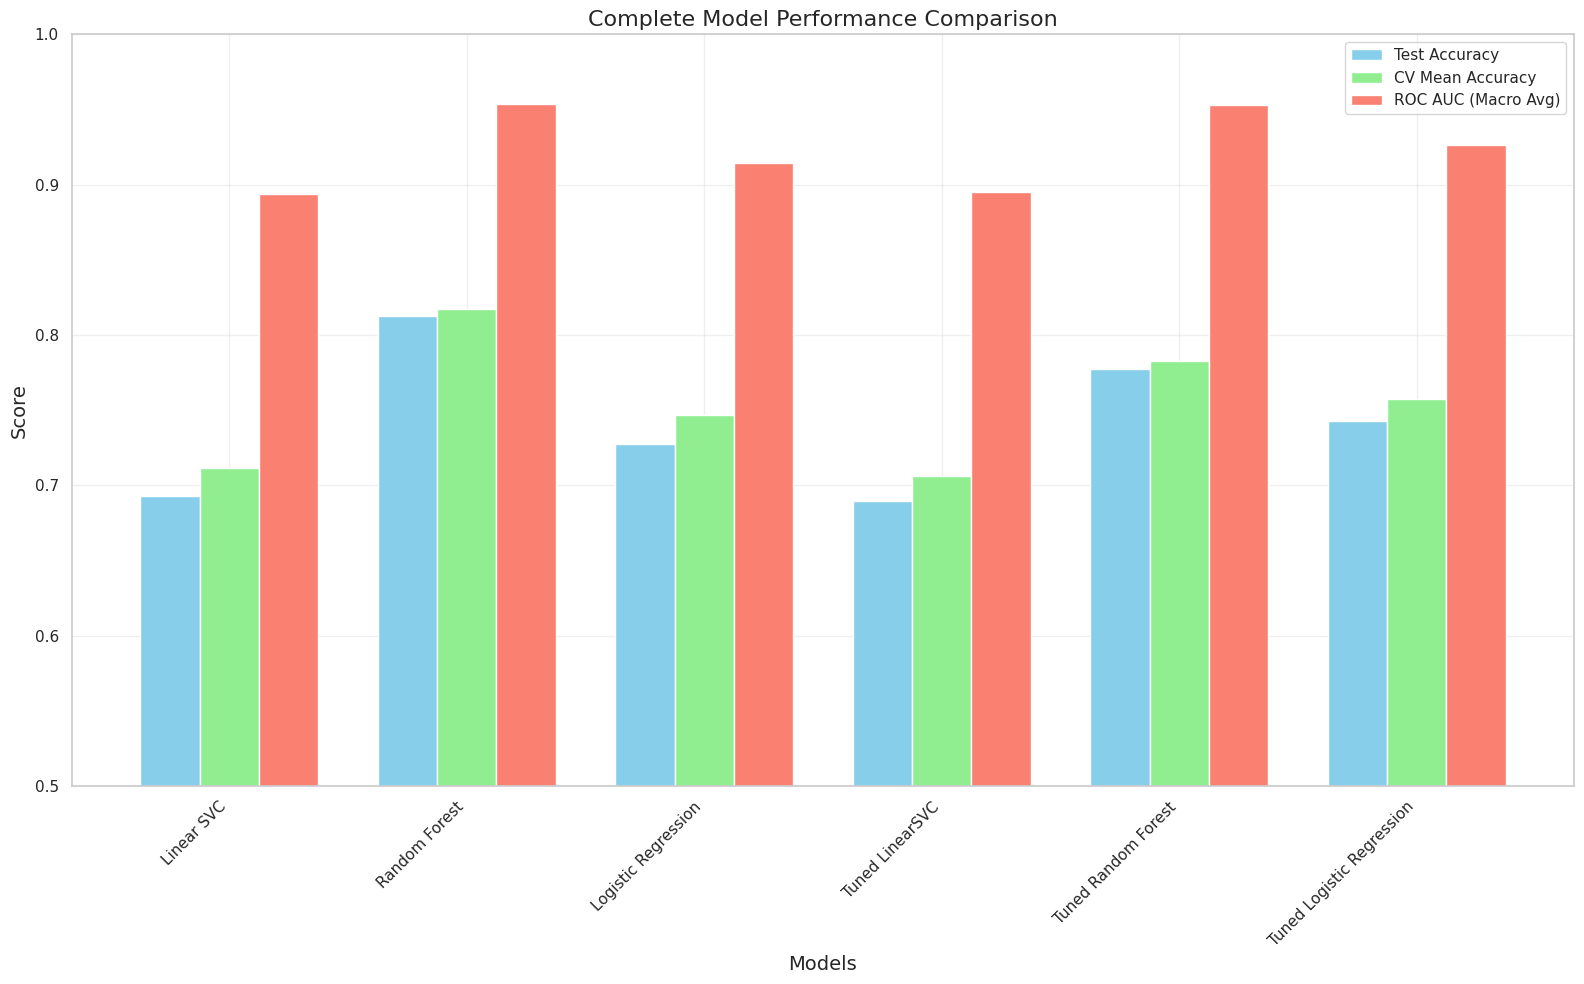


All Models Comparison (Sorted by Test Accuracy):
                       Model  Test Accuracy  CV Mean Accuracy   ROC AUC
1              Random Forest       0.812769          0.816974  0.953898
4        Tuned Random Forest       0.777440          0.782665  0.952735
5  Tuned Logistic Regression       0.743055          0.757660  0.926052
2        Logistic Regression       0.727330          0.746783  0.914336
0                 Linear SVC       0.693050          0.711399  0.894026
3            Tuned LinearSVC       0.689800          0.705947  0.894925


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compare tuned model performances
tuned_models = ['Tuned LinearSVC', 'Tuned Random Forest', 'Tuned Logistic Regression']
tuned_accuracies = [lsvc_tuned_results['accuracy'], rf_tuned_results['accuracy'], lr_tuned_results['accuracy']]
tuned_cv_means = [lsvc_tuned_results['cv_scores'].mean(), rf_tuned_results['cv_scores'].mean(), lr_tuned_results['cv_scores'].mean()]
tuned_cv_stds = [lsvc_tuned_results['cv_scores'].std(), rf_tuned_results['cv_scores'].std(), lr_tuned_results['cv_scores'].std()]

# Handle ROC AUC (extract macro-average if multiclass)
tuned_roc_aucs = []
for result in [lsvc_tuned_results, rf_tuned_results, lr_tuned_results]:
    if isinstance(result['roc_auc'], dict):
        # For multiclass, use macro-average
        tuned_roc_aucs.append(np.mean(list(result['roc_auc'].values())))
    else:
        # For binary classification, use directly
        tuned_roc_aucs.append(result['roc_auc'])

# Create a comparison DataFrame
tuned_comparison_df = pd.DataFrame({
    'Model': tuned_models,
    'Test Accuracy': tuned_accuracies,
    'CV Mean Accuracy': tuned_cv_means,
    'CV Std': tuned_cv_stds,
    'ROC AUC': tuned_roc_aucs
})

print("Tuned Model Comparison:")
print(tuned_comparison_df)

# Visualize tuned model comparison
plt.figure(figsize=(14, 8))

bar_width = 0.25
index = np.arange(len(tuned_models))

plt.bar(index, tuned_accuracies, bar_width, label='Test Accuracy', color='skyblue')
plt.bar(index + bar_width, tuned_cv_means, bar_width, label='CV Mean Accuracy', color='lightgreen')
plt.bar(index + 2*bar_width, tuned_roc_aucs, bar_width, label='ROC AUC (Macro Avg)', color='salmon')

plt.xlabel('Models', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Tuned Model Performance Comparison', fontsize=16)
plt.xticks(index + bar_width, tuned_models)
plt.ylim(0.5, 1.0)  # Adjusted range based on your scores
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Combine original and tuned models for comparison
all_models = models + tuned_models
all_accuracies = accuracies + tuned_accuracies
all_cv_means = cv_means + tuned_cv_means
all_roc_aucs = roc_aucs + tuned_roc_aucs  # Make sure original roc_aucs are also processed

# Create a comprehensive comparison plot
plt.figure(figsize=(16, 10))
bar_width = 0.25
index = np.arange(len(all_models))

plt.bar(index, all_accuracies, bar_width, label='Test Accuracy', color='skyblue')
plt.bar(index + bar_width, all_cv_means, bar_width, label='CV Mean Accuracy', color='lightgreen')
plt.bar(index + 2*bar_width, all_roc_aucs, bar_width, label='ROC AUC (Macro Avg)', color='salmon')

plt.xlabel('Models', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Complete Model Performance Comparison', fontsize=16)
plt.xticks(index + bar_width, all_models, rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a dataframe for all models comparison
all_comparison_df = pd.DataFrame({
    'Model': all_models,
    'Test Accuracy': all_accuracies,
    'CV Mean Accuracy': all_cv_means,
    'ROC AUC': all_roc_aucs
})

print("\nAll Models Comparison (Sorted by Test Accuracy):")
print(all_comparison_df.sort_values('Test Accuracy', ascending=False))